In [ ]:
%load_ext autoreload
%autoreload 2

## Basic setup

In [ ]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [ ]:
data_dir = Path('../data/intestine_dev/')
#data_path = data_dir / "adata_Huycke_1119.h5ad"
#data_path = data_dir / "intestine_adata_processed_concord_Huycke_intestine_Nov20.h5ad"
#data_path = data_dir/'adata_huycke_Dec31-1151.h5ad'
#data_path = data_dir/'adata_huycke_Jan04-1936.h5ad'
#data_path = data_dir / 'adata_huycke_Jan05-1211.h5ad'
#data_path = data_dir / 'adata_huycke_Jan07-1351.h5ad'
data_path = data_dir / 'adata_huycke_Jan08-1324.h5ad'
data_path = data_dir / 'adata_huycke_Mar31-2314.h5ad'
adata = sc.read(
    data_path
)



# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# ccd.ul.score_cell_cycle(adata, organism='Mm')

In [ ]:
# # Get seurat result
# adata_seurat = sc.read(data_dir / 'intestine_adata_2025.h5ad')
# # check if the cell order is the same
# assert np.all(adata.obs.index == adata_seurat.obs.index)
# remove_keys = ['Concord-decoder_Dec30-1500', 'Concord-decoder_Jan06-1446', 'Concord-decoder_Jan06-1531',
#                'Concord_Dec31-1057', 'Concord_Jan04-1936', 'Concord_Jan04-1936_UMAP', 'Concord_Jan06-1447', 'Concord_Jan06-1531', 'Seurat', 'Seurat_UMAP', 'Seurat_UMAP_3D']
# for key in remove_keys:
#     if key in adata.obsm.keys():
#         del adata.obsm[key]

# adata.obsm['Seurat'] = adata_seurat.obsm['Seurat'].copy()

In [ ]:
proj_name = "benchmark_Huycke"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
seed = 0
ccd.ul.set_seed(seed)
file_suffix = f"{time.strftime('%b%d-%H%M')}"

In [ ]:
concord_keys = ["Concord", 'Concord-decoder']
other_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "Seurat"]
combined_keys = other_keys + concord_keys

In [ ]:
# #Load runs
# new_run_files = [
#     Path('../save/dev_huycke_1230-Jan06/') / "obsm_Harmony_Jan06-1046.h5",
#     Path('../save/dev_huycke_1230-Jan06/') / "obsm_Scanorama_Jan06-1026.h5",
#     Path('../save/dev_huycke_1230-Jan06/') / "obsm_Liger_Jan06-1026.h5",
#     Path('../save/dev_huycke_1230-Jan06/') / "obsm_scVI_Jan06-1026.h5",
# ]

# remove_keys = ['Concord_concord_Huycke_intestine_Nov19', 'Concord_concord_Huycke_intestine_Nov19_UMAP',
#                'Concord_concord_Huycke_intestine_Nov19_UMAP_3D', 'Concord_concord_Huycke_intestine_Nov20', 'Concord_concord_Huycke_intestine_Nov20_UMAP',
#                'Concord_concord_Huycke_intestine_Nov20_UMAP_3D'] + other_keys
# for key in remove_keys:
#     if key in adata.obsm.keys():
#         del adata.obsm[key]
        
# for file in new_run_files:
#     print(file)
#     new_obsm = ccd.ul.load_obsm_from_hdf5(file)
#     # add to adata
#     for key in new_obsm.keys():
#         if key not in adata.obsm.keys():
#             print(f"Adding {key}")
#             adata.obsm[key] = new_obsm[key]

# adata.obsm['Seurat'] = adata.obsm['Seurat_int_PCA'].copy()
# adata.obsm['Seurat_UMAP'] = adata.obsm['Seurat_int_UMAP'].copy()
# adata.obsm['Seurat_UMAP_3D'] = adata.obsm['Seurat_int_UMAP_3D'].copy()
# adata.obsm['Unintegrated'] = adata.obsm['X_pca'].copy()
# del adata.obsm['Seurat_int_PCA']
# del adata.obsm['Seurat_int_UMAP']
# del adata.obsm['Seurat_int_UMAP_3D']
# adata.obsm

In [ ]:
ccd.set_verbose_mode(True)
timer = ccd.ul.Timer()
time_log = {}

In [ ]:
feature_list = ccd.ul.select_features(adata, n_top_features=10000, flavor='seurat_v3')
file_suffix = f"{time.strftime('%b%d-%H%M')}"
concord_args = {
        'adata': adata,
        'input_feature': feature_list,
        'batch_size': 128,
        'latent_dim': 50,
        'encoder_dims':[500],
        'decoder_dims':[500],
        'augmentation_mask_prob': 0.3, 
        'clr_temperature': 0.3,
        'p_intra_knn': 0.1,
        'sampler_knn': 300,
        'min_p_intra_domain': .8,
        'n_epochs': 15,
        'domain_key': 'LaneID',
        'verbose': True,
        'inplace': False,
        'seed': seed,
        'device': device,
        'save_dir': save_dir
    }


In [ ]:
with timer:
    output_key = f'Concord'
    cur_ccd = ccd.Concord(use_decoder=False, **concord_args)
    cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key)

time_log[output_key] = timer.interval

adata.obsm[output_key] = cur_ccd.adata.obsm[output_key]

# with timer:
#     output_key = f'Concord-decoder'
#     cur_ccd = ccd.Concord(use_decoder=True, **concord_args)
#     cur_ccd.encode_adata(input_layer_key='X_log1p', output_key=output_key)

# time_log[output_key] = timer.interval

# adata.obsm[output_key] = cur_ccd.adata.obsm[output_key]


In [ ]:
# Load model and predict latent
config_file = '../save/dev_benchmark_Huycke-Jan07/config_Jan07-1248.json'
model_file = '../save/dev_benchmark_Huycke-Jan07/final_model_Jan07-1248.pt'
# Load config
concord_args = ccd.ul.load_json(str(config_file))
concord_args['pretrained_model'] = model_file
cur_ccd = ccd.Concord(adata=adata, **concord_args)
cur_ccd.init_model()
cur_ccd.init_dataloader(input_layer_key='X', preprocess=True, train_frac=1.0, use_sampler=False)
encoded, _,_,_,_, latent_matrices = cur_ccd.predict(cur_ccd.loader, 
                                                    return_decoded=False, decoder_domain=None,
                                                    return_latent=True,
                                                    return_class=False, return_class_prob=False)

In [ ]:
for key, val in latent_matrices.items():
    adata.obsm['Concord'+'_'+key] = val

# Save obsm
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
save_dir / f"obsm_{file_suffix}.h5"

In [ ]:
basis = 'Concord_re'
adata.obsm['Concord_re'] = encoded
ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)

In [ ]:
# Run umap and PCA for all latent embeddings
#for basis in combined_keys:
for basis in other_keys:
    if True:
        print("Running UMAP for", basis)
        if basis not in adata.obsm:
            print(f"{basis} not found.")
            continue
        #if 'UMAP' not in basis:
        ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)
    else:
        print(f"UMAP already exists for {basis}")

# Save obsm 
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
adata.write_h5ad(data_dir / f"adata_huycke_{file_suffix}.h5ad")
print(data_dir / f"adata_huycke_{file_suffix}.h5ad")


In [ ]:
for basis in ['Seurat']:
    print("Running UMAP for", basis)
    if basis not in adata.obsm:
        print(f"{basis} not found.")
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
    #ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)

ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
adata.write_h5ad(data_dir / f"adata_huycke_{file_suffix}.h5ad")
print(data_dir / f"adata_huycke_{file_suffix}.h5ad")

In [ ]:
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")
adata.write_h5ad(data_dir / f"adata_huycke_{file_suffix}.h5ad")
print(data_dir / f"adata_huycke_{file_suffix}.h5ad")

In [ ]:
# Leiden cluster
sc.pp.neighbors(adata, n_neighbors=30, use_rep='Concord')
sc.tl.leiden(adata, key_added='leiden_global_Concord', resolution=0.5, random_state=seed)

In [ ]:
# Reannotate broad cell type based on cluster
adata.obs['broad_cell_type'] = adata.obs['leiden_global_Concord'].astype(str)
cluster_mapping = {
    'Epithelial': [2,20,24],
    'Endothelial': [9],
    'Erythrocyte': [5],
    'MSC': [0,25,8,21,13,26],
    'Mesenchymal (Pdgfra)': [3,4,7,23],
    'Smooth muscle': [1,14,10],
    'Mesothelial': [18],
    'ENS': [11,12,16,22],
    'Myeloid': [6,17,27],
    'Lymphoid': [15],
    'Doublet-like': [19]
}
for key, value in cluster_mapping.items():
    adata.obs['broad_cell_type'] = adata.obs['broad_cell_type'].replace({str(v):key for v in value})

adata.obs['broad_cell_type'].value_counts()

In [ ]:
# Define color palette for broad_cell_type_qz
adata.obs['stage'] = adata.obs['MouseAge_combined']
_, _, celltype_pal = ccd.pl.get_color_mapping(adata, 'cell_type', pal='Paired', seed=seed)
_, _, broad_celltype_pal = ccd.pl.get_color_mapping(adata, 'broad_cell_type', pal='tab20', seed=seed)
broad_celltype_pal['Doublet-like'] = '#757575'
_, _, mes_pal = ccd.pl.get_color_mapping(adata, 'mes_subtype', pal='Paired', seed=seed)
_, _, epi_pal = ccd.pl.get_color_mapping(adata, 'epi_subtype', pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata,'batch', pal='Set1', seed=seed)
_, _, phase_pal = ccd.pl.get_color_mapping(adata, 'phase', pal='Set1', seed=seed)
_, _, seg_pal = ccd.pl.get_color_mapping(adata, 'seg_classify', pal='tab10', seed=seed)
_, _, lane_pal = ccd.pl.get_color_mapping(adata,'LaneID', pal='Paired', seed=7)
stage_pal = {
    '12.5':"midnightblue", 
    '13.5':"dodgerblue", 
    '14.5':"seagreen", 
    '15.5':"#00C000", 
    '16.5':"#EEC900", 
    '17.5':"#FF7F00", 
    '18.5':"#FF0000"
}
pal = {"cell_type": celltype_pal,
    "broad_cell_type": broad_celltype_pal,
    "mes_subtype": mes_pal,
    "epi_subtype": epi_pal,
    "batch": batch_pal,
    'phase': phase_pal,
    'stage': stage_pal,
    'seg_classify': seg_pal,
    'LaneID': lane_pal}

In [ ]:
basis= f'Concord'
#basis= f'Concord-decoder'
show_basis = basis + '_UMAP'
show_cols = ['stage', 'phase', 'batch', 'cell_type', 'broad_cell_type', "mes_subtype", 'epi_subtype', 'seg_classify', 'LaneID', 'leiden_global_Concord']
show_cols = ['broad_cell_type']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(13,11), dpi=600, ncols=3, font_size=10, point_size=1, legend_loc='upper right',
    save_path=save_dir / f"{show_basis}_{file_suffix}.pdf"
)

In [ ]:
#show_cols = ['batch', 'broad_cell_type', 'cell_type', 'mes_subtype', 'phase']
basis = 'Concord-decoder'
show_cols = ['epi_subtype']
for col in show_cols:
    show_basis = f'{basis}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata, basis=show_basis, color_by=col,
            pal = pal,
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=1, opacity=0.8, width=1500, height=1000, static=True
        )

In [ ]:
# Run umap and PCA for all latent embeddings
other_keys = ['scVI', 'Seurat']
for basis in other_keys:
    print("Running UMAP for", basis)
    if basis not in adata.obsm:
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP_3D', n_components=3, n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=seed)

# Save resulting adata
adata.write_h5ad(data_dir / f"adata_huycke_{file_suffix}.h5ad")
print(data_dir / f"adata_huycke_{file_suffix}.h5ad")

In [ ]:
show_cols = ['batch', 'broad_cell_type', 'cell_type', 'mes_subtype', 'phase', 'seg_classify', 'LaneID', 'stage']
basis = 'Concord'
basis = 'scVI'
basis = 'Seurat'
for col in show_cols:
    show_basis = f'{basis}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata, basis=show_basis, color_by=col,
            pal = pal, 
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=1, opacity=0.8, width=1300, height=1000, 
            autosize=True,
            static=False
        )

### Plot

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

show_keys = combined_keys
show_cols = ['stage', 'phase', 'batch', 'LaneID', 'broad_cell_type', 'cell_type', 'epi_subtype', "mes_subtype", 'seg_classify']
#show_cols = ['LaneID']
basis_types = ['UMAP']

font_size=10
point_size=.2
alpha=0.8
figsize=(10,1.4)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))


with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='pdf'
    )


In [ ]:
# Perform leiden clustering on 3D UMAP
sc.pp.neighbors(adata, n_neighbors=30, use_rep='Concord_UMAP_3D')
sc.tl.leiden(adata, key_added='leiden_global_Concord_UMAP_3D', resolution=0.1, random_state=seed)


In [ ]:
show_cols = ['stage', 'phase', 'batch', 'LaneID', 'broad_cell_type', 'cell_type', 'epi_subtype', "mes_subtype", 'seg_classify']
show_cols = ['leiden_global_Concord_UMAP_3D']
for col in show_cols:
    ccd.pl.plot_embedding_3d(
        adata, basis='Concord_UMAP_3D', color_by=col,
        pal=pal,
        save_path=save_dir / f'Intestine_Concord_UMAP_3D_{col}_{file_suffix}.html',
        point_size=1, opacity=0.8, width=1500, height=1000
    )

In [ ]:
show_cols = ['stage', 'phase', 'batch', 'LaneID', 'broad_cell_type', 'cell_type', 'epi_subtype', "mes_subtype", 'seg_classify']
show_cols = ['phase', 'broad_cell_type']
concord_keys = ['Concord']
#azims = [0, 45, 90, 135, 180, 225, 270, 315]
# azims = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
# elevs = [30, 45, 60]
azims =[330]
elevs = [10]
for azim in azims:
    for elev in elevs:
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=2,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.05,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}',
                save_format='pdf',
            )


In [ ]:
# Cross tab results
import pandas as pd

cross_tab = pd.crosstab(adata.obs['broad_cell_type'], adata.obs['leiden_global_Concord_UMAP_3D'])
print(cross_tab)
#Assign each cluster to its majority cell type based on cross tab
cluster_mapping = cross_tab.idxmax(axis=0).to_dict()
# Reverse mapping to append clusters to each cell type
cell_type_mapping = {}
for key, value in cluster_mapping.items():
    if value not in cell_type_mapping:
        cell_type_mapping[value] = []
    cell_type_mapping[value].append(key)
cell_type_mapping


In [ ]:
import re
show_cols = ['broad_cell_type']
concord_keys = ['Concord_UMAP_3D']
azims =[330]
elevs = [10]
figsize=(10, 5)

cell_type_groups = [
    #['Epithelial'],
    ['MSC', 'Smooth muscle'],
    # ['Mesenchymal (Pdgfra)'],
    #['ENS'],
    # ['Myeloid']
]

ct_view_angles = {
    'Epithelial' : {"View 1": (10,50),"View 2": (130,10)},
    'ENS': {"View 1": (90,0)},
    'MSC': {"View 1": (270,30)},
}

for cts in cell_type_groups:
    ct_group_clus = []
    for ct in cts:
        ct_group_clus.extend(cell_type_mapping[ct])
    
    adata_ct = adata[adata.obs['leiden_global_Concord_UMAP_3D'].isin(ct_group_clus) & (adata.obs['broad_cell_type'].isin(cts))].copy()
    highlight_indices = adata_ct.obs.index
    not_highlight_indices = adata.obs.index.difference(highlight_indices)
    # Set those not highlighted to grey with alpha=0.1
    fig = plt.figure(figsize=figsize, dpi=600, constrained_layout=True)
    ax = fig.add_subplot(1, 1, i+1, projection='3d')
    # Plot global view
    for azim in azims:
        for elev in elevs:
            with plt.rc_context(rc=custom_rc):
                ccd.pl.plot_embedding_3d_matplotlib(
                    adata=adata,
                    basis=concord_keys[0],         # or however you name your embeddings
                    color_by=show_cols[0],  # columns or gene names to color by
                    ax = ax,
                    pal=pal,    
                    rasterized=True,                   # Points get rasterized
                    point_size=2,
                    alpha=0.8,
                    elev=elev,
                    azim=azim,
                    zoom_factor=0.05,
                    show_grid=True,
                    show_axis_labels=False,            # Turn off axis labels
                    show_ticks=False,                  # No ticks
                    show_legend=False,
                    tick_label_font_size=6,
                    highlight_indices=not_highlight_indices,
                    highlight_color='lightgrey',
                    highlight_alpha=1,
                    highlight_size = 1
                )
                ax.set_title(key, fontsize=7)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_zticks([])

                # Add view

                # Get coords range based on adata_ct
                emb_ct = adata_ct.obsm[concord_keys[0]]
                x_min, x_max = emb_ct[:,0].min(), emb_ct[:,0].max()
                y_min, y_max = emb_ct[:,1].min(), emb_ct[:,1].max()
                z_min, z_max = emb_ct[:,2].min(), emb_ct[:,2].max()

                # Compute center of the subsetted data
                x_center, y_center, z_center = (x_min + x_max) / 2, (y_min + y_max) / 2, (z_min + z_max) / 2

                eye_positions = ct_view_angles[cts[0]]
                for view, (azim, elev) in eye_positions.items():

                    # Compute eye position
                    r_factor = 6  # Scaling factor to place the eye outside the dataset range
                    azim_rad = np.radians(azim)
                    elev_rad = np.radians(elev)

                    x_eye = x_center + r_factor * np.cos(elev_rad) * np.cos(azim_rad)
                    y_eye = y_center + r_factor * np.cos(elev_rad) * np.sin(azim_rad)
                    z_eye = z_center + r_factor * np.sin(elev_rad)

                    ax.scatter(x_eye, y_eye, z_eye, color="red", s=50, zorder=4)
                    # Add label
                    ax.text(x_eye, y_eye, z_eye, f"{view}", fontsize=5, color='black', zorder=5)

                    # Compute view direction vector (eye to center)
                    dir_x = x_center - x_eye
                    dir_y = y_center - y_eye
                    dir_z = z_center - z_eye

                    # Normalize the direction vector
                    norm = np.sqrt(dir_x**2 + dir_y**2 + dir_z**2)
                    dir_x /= norm
                    dir_y /= norm
                    dir_z /= norm

                    arrow_length = 3.0  # Adjust this value to make arrows longer

                    # Scale the direction vector
                    dir_x *= arrow_length
                    dir_y *= arrow_length
                    dir_z *= arrow_length

                    ax.quiver(
                        x_eye, y_eye, z_eye,
                        dir_x, dir_y, dir_z,
                        color="black", linewidth=1, arrow_length_ratio=0.0,
                        zorder=6
                    )                

                out_fn = f"{save_dir}/all_latent_3D_{show_cols[0]}_{concord_keys[0]}_{file_suffix + f'_azim{azim}_elev{elev}' + f'_{cts[0]}'}.pdf"
                plt.savefig(out_fn, bbox_inches='tight')
                plt.show()
                plt.close()


### 3D Animation movie

In [ ]:
col = 'broad_cell_type'
azims =[330]
elevs = [10]
ccd.pl.plot_rotating_embedding_3d_to_mp4(adata, embedding_key=show_basis, color_by=col, save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.mp4', 
                                         pal=pal,
                                      point_size=1, opacity=0.8, 
                                      width=1000, height=1000, dpi=300,
                                      elev=10, azim=330,
                                      rotation_duration=10, num_steps=300,
                                      legend_itemsize=100, font_size=16, seed=42)

### Visualize individual cell types

In [ ]:
unique_broad_cell_types = adata.obs['broad_cell_type'].unique()
all_cts = [ct for ct in list(unique_broad_cell_types) + ['Immune'] if ct != 'Doublet-like']
all_cts

In [ ]:
import re
for ct in all_cts:
    sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
    print(f"Running UMAP for {sanitized_ct}")
    if ct == 'Immune':
        ct = ['Myeloid', 'Lymphoid']
    else:
        ct = [ct]
    
    adata_subset = adata[adata.obs['broad_cell_type'].isin(ct)].copy()
    #adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
    for basis in combined_keys:
        if f'{basis}_UMAP_sub' not in adata.obsm:

            ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_sub', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
            #ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
        
        sc.pp.neighbors(adata_subset, n_neighbors=30, use_rep='Concord')
        sc.tl.leiden(adata_subset, resolution=1.0, key_added='leiden_Concord_sub')

    #adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
    adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")


In [ ]:
# Load and plot
all_cts = list(unique_broad_cell_types) + ['Immune']
import re
for ct in all_cts:
    print("Plotting UMAP for", ct)
    sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
    adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
    # Run leiden cluster
    adata_subset.obs['stage'] = adata_subset.obs['MouseAge_combined'].astype(float)
    show_keys = combined_keys
    show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify']
    show_cols = ['LaneID']
    #show_cols = ['epi_subtype', 'mes_subtype']
    basis_types = ['UMAP_sub']

    font_size=10
    point_size=3
    alpha=0.8
    figsize=(10,1.35)
    ncols = len(show_keys)
    nrows = int(np.ceil(len(show_keys) / ncols))


    with plt.rc_context(rc=custom_rc):
        ccd.pl.plot_all_embeddings(
            adata_subset,
            show_keys,
            color_bys=show_cols,
            basis_types=basis_types,
            pal=pal,
            font_size=font_size,
            point_size=point_size,
            alpha=alpha,
            figsize=figsize,
            ncols=ncols,
            seed=seed,
            save_dir=save_dir,
            legend_loc='upper right',
            file_suffix=file_suffix+f"_{sanitized_ct}",
            dpi=600,
            save_format='pdf'
        )

In [ ]:
all_cts = list(unique_broad_cell_types) + ['Immune']
adata_subsets = {}
for ct in all_cts:
    sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
    adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
    adata_subsets[sanitized_ct] = adata_subset

In [ ]:
ccd.ul.anndata_to_viscello(adata, data_dir / f"cello_{proj_name}_{file_suffix}", project_name = proj_name, organism='mmu')

In [ ]:
viscello_dir = str(data_dir / f"cello_{proj_name}_{file_suffix}")
ccd.ul.update_clist_with_subsets(global_adata = adata, adata_subsets = adata_subsets, viscello_dir = viscello_dir)

You can optionally convert the result to VisCello (https://github.com/kimpenn/VisCello) for interactive exploration.

## MSC

In [ ]:
cts = ['MSC', 'Smooth muscle']
sanitized_ct = 'MSC_muscle'
ct_group_clus = []
for ct in cts:
    ct_group_clus.extend(cell_type_mapping[ct])

adata_ct = adata[adata.obs['leiden_global_Concord_UMAP_3D'].isin(ct_group_clus) & (adata.obs['broad_cell_type'].isin(cts))].copy()

# Perform leiden
sc.pp.neighbors(adata_ct, n_neighbors=30, use_rep='Concord')
sc.tl.leiden(adata_ct, key_added='leiden_MSC', resolution=0.5, random_state=seed)

# Assign cell subtype based on leiden clustering
adata_ct.obs['MSC_subtype'] = adata_ct.obs['leiden_MSC'].astype(str)
cluster_mapping = {
    'Smooth muscle': ['1', '5','6', '7', '9','10','13'],
    'MSC (Kit+)': ['0', '2','3', '8', '11','15','16', '17'],
    'MSC (Slit2 high)': ['4', '14'],
    'MSC (Ebf1 high)': ['12']
}

for key, value in cluster_mapping.items():
    adata_ct.obs['MSC_subtype'] = adata_ct.obs['MSC_subtype'].replace({str(v):key for v in value})

adata_ct.obs['MSC_subtype'].value_counts()

In [ ]:
sanitized_ct = 'MSC_muscle'
adata_ct.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
print(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")

In [ ]:
sanitized_ct = 'MSC_muscle'
adata_ct = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")

In [ ]:
pal['broad_cell_type']

In [ ]:
_, _, msc_pal = ccd.pl.get_color_mapping(adata_ct, 'MSC_subtype', pal='Set2', seed=seed)
msc_pal['Smooth muscle'] = pal['broad_cell_type']['Smooth muscle']
pal['MSC_subtype'] = msc_pal

In [ ]:
import re
#show_cols = ['phase', 'broad_cell_type', 'seg_classify']
#show_cols = ['epi_subtype','phase','seg_classify', 'Bex1', 'Bex4', 'Onecut2', 'Lgr5']
concord_keys = ['Concord']
azims = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330]
elevs = [0,-15,-30,-45]

#show_cols = ['phase', 'broad_cell_type', 'Ebf1', 'Slit2', 'Kit', 'Acta2']



show_cols = ['MSC_subtype']
highlight_indices = adata_ct.obs.index
not_highlight_indices = adata.obs.index.difference(highlight_indices)
# Set those not highlighted to grey with alpha=0.1

# Plot global view
ct_view = ct_view_angles[cts[0]]
for view in ct_view.keys():
    azim, elev = ct_view[view]
# for azim in azims:
#     for elev in elevs:
    with plt.rc_context(rc=custom_rc):
        ccd.pl.plot_all_embeddings_3d(
            adata=adata_ct,
            combined_keys=concord_keys,         # or however you name your embeddings
            color_bys=show_cols,  # columns or gene names to color by
            basis_types=['UMAP_3D'],              # or whatever naming convention is in adata.obsm
            pal=pal,    
            ncols=2,
            rasterized=True,                   # Points get rasterized
            point_size=15,
            alpha=0.8,
            elev=elev,
            azim=azim,
            zoom_factor=0.0,
            show_grid=True,
            show_axis_labels=False,            # Turn off axis labels
            show_ticks=False,                  # No ticks
            show_legend=False,
            tick_label_font_size=6,
            legend_font_size=6,
            vmax_quantile = .975,
            save_dir=save_dir,
            file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f'_{cts[0]}',
            save_format='pdf',
            figsize=(10, 7)
        )

                

In [ ]:
#show_cols = ['batch', 'broad_cell_type', 'cell_type', 'mes_subtype', 'phase']
basis = 'Concord'
show_cols = ['leiden_MSC', 'broad_cell_type','cell_type']
#show_cols = ['Ebf1', 'Slit2', 'Kit', 'Acta2']
for col in show_cols:
    show_basis = f'{basis}_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata_ct, basis=show_basis, color_by=col,
            pal = pal,
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=2, opacity=0.8, width=1500, height=1000, static=True
        )

## Macrophage analysis

In [ ]:
import re
ct = 'Macrophage'
sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")

In [ ]:

macrophage_clusters = ['17','6']
adata_subset = adata[adata.obs['leiden_global_Concord'].isin(macrophage_clusters)].copy()


#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
for basis in combined_keys:
    if f'{basis}_UMAP_sub' not in adata.obsm:

        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_sub', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
    
    sc.pp.neighbors(adata_subset, n_neighbors=30, use_rep='Concord')
    sc.tl.leiden(adata_subset, resolution=1.0, key_added='leiden_Concord_sub')

adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")

In [ ]:
viscello_dir = str(data_dir / f"cello_{proj_name}_{file_suffix}")
adata_subsets = {
    sanitized_ct: adata_subset
}
ccd.ul.update_clist_with_subsets(global_adata = adata, adata_subsets = adata_subsets, viscello_dir = viscello_dir)

In [ ]:
adata_subset = sc.read(data_dir / f"adata_huycke_Macrophage_Jan08-1324.h5ad")

In [ ]:
# Annotate macrophage clusters based on leiden_Concord_sub
adata_subset.obs['mac_subtype'] = adata_subset.obs['leiden_Concord_sub'].astype(str)
cluster_mapping = {
    'Monocyte': ['15'],
    'mo-DC/DC': ['13'],
    'Ccr2/Lyz2+ Macrophage': ['11', '14', '7'],
    'Apol7c/Timd4/Mmp9+ gMac': ['0', '6', '2','10', '1'],
    'Differentiating monocyte': ['12', '4'],
    'Lyve1+Mrc1+ M2‐like macrophage': ['9','5', '3', '8']
}
for key, value in cluster_mapping.items():
    adata_subset.obs['mac_subtype'] = adata_subset.obs['mac_subtype'].replace({str(v):key for v in value})

# Map back to global adata
adata.obs['mac_subtype'] = np.nan
adata.obs.loc[adata_subset.obs.index, 'mac_subtype'] = adata_subset.obs['mac_subtype']
#adata.write_h5ad(data_dir / f"adata_huycke_{file_suffix}.h5ad")
#adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
_, _, mac_pal = ccd.pl.get_color_mapping(adata, 'mac_subtype', pal='tab10', seed=seed)
pal['mac_subtype'] = mac_pal

In [ ]:
print("Plotting UMAP for", ct)
sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
# Run leiden cluster
adata_subset.obs['stage'] = adata_subset.obs['MouseAge_combined'].astype(str)
show_keys = combined_keys
#show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify', 'mac_subtype']
show_cols = ['phase']
#show_cols = ['mac_subtype', 'phase']
#show_cols = ['epi_subtype', 'mes_subtype']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
adata_subset.obsm.keys()

In [ ]:
show_cols = ['stage', 'phase', 'batch', 'LaneID', 'broad_cell_type', 'cell_type', 'epi_subtype', "mes_subtype", 'seg_classify']
show_cols = ['phase']
concord_keys = ['Concord']
#azims = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
azims =[130]
elevs = [30]
for azim in azims:
    for elev in elevs:
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata_subset,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D_sub'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=20,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.05,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f"_{sanitized_ct}",
                save_format='pdf',
            )

In [ ]:
# Cross tab mac_subtype and seg_classify and show enrichment as pie chart
cross_tab = pd.crosstab(adata_subset.obs['mac_subtype'], adata_subset.obs['seg_classify'])
cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab


In [ ]:
show_cols = ['Ccr2', 'Mrc1', 'Apol7c']
basis_types = ['UMAP_sub']
show_keys = ['Concord']
font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        vmax_quantile=0.975,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [20]:
# Composition analysis of macrophage state across time points

state_count = adata_subset.obs.groupby(['mac_subtype', 'MouseAge_combined']).size().unstack(fill_value=0)
# Get composition of each state across time points
state_composition = state_count.div(state_count.sum(axis=0), axis=1)
state_composition

MouseAge_combined,13.5,14.5,15.5,16.5,18.5
mac_subtype,,,,,
Apol7c/Timd4/Mmp9+ gMac,0.104895,0.234043,0.367624,0.448778,0.431694
Ccr2/Lyz2+ Macrophage,0.052448,0.158055,0.152313,0.177162,0.153005
Differentiating monocyte,0.010490,0.045593,0.176236,0.123120,0.073770
Lyve1+Mrc1+ M2‐like macrophage,0.818182,0.544073,0.242424,0.155545,0.136612
Monocyte,0.000000,0.000000,0.034290,0.036184,0.057377
mo-DC/DC,0.013986,0.018237,0.027113,0.059211,0.147541


<Figure size 300x200 with 0 Axes>

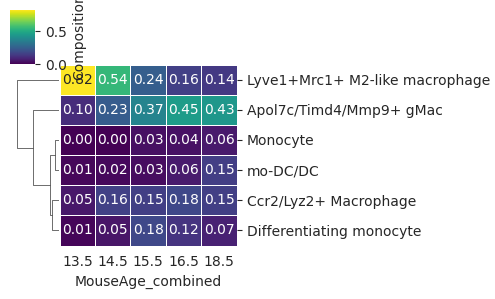

In [32]:
# Plot heatmap of state composition
import seaborn as sns
plt.figure(figsize=(3, 2))
with plt.rc_context(rc=custom_rc):
    sns.set_style("whitegrid")
    # Create a heatmap of the state composition
    sns.clustermap(state_composition, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={'label': 'Composition'}, row_cluster=True, col_cluster=False, annot_kws={"size": 10}, figsize=(5,3))
    # Save the state composition heatmap
    state_composition_heatmap_path = save_dir / f'state_composition_heatmap_{sanitized_ct}_{file_suffix}.pdf'
    plt.savefig(state_composition_heatmap_path, bbox_inches='tight')

In [38]:
# Plot 3D umap of macrophage states
show_cols = ['mac_subtype']
for col in show_cols:
    show_basis = f'Concord_UMAP_3D'
    ccd.pl.plot_embedding_3d(
            adata_subset, basis=show_basis, color_by=col,
            pal = pal,
            save_path=save_dir / f'{show_basis}_{col}_{file_suffix}.html',
            point_size=2, opacity=0.8, width=1500, height=1000, static=True
        )

../save/dev_benchmark_Huycke-May30/Concord_UMAP_3D_mac_subtype_May30-1811_mac_subtype.png


### Epithelial analysis

In [ ]:
ct = 'Epithelial'

sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
epi_exclude = ['doublet-like (Collagen+BMP+)', 'doublet-like (Lyve1+Cldn5+)', 'Epithelial (low mRNA)']
adata_subset = adata_subset[~adata_subset.obs['epi_subtype'].isin(epi_exclude)].copy()
adata_subset.shape

In [ ]:
for basis in combined_keys:
    if f'{basis}_UMAP_sub' not in adata.obsm:
        #ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_sub', n_components=2, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)
        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=30, min_dist=0.1, metric='cosine', random_state=seed)


In [ ]:
adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
viscello_dir = str(data_dir / f"cello_{proj_name}_Jan08-1324")
adata_subsets = {
    sanitized_ct: adata_subset
}
ccd.ul.update_clist_with_subsets(global_adata = adata, adata_subsets = adata_subsets, viscello_dir = viscello_dir)

In [ ]:
_, _, epi_pal = ccd.pl.get_color_mapping(adata, 'epi_subtype', pal='tab10', seed=seed)
pal['epi_subtype'] = epi_pal

print("Plotting UMAP for", ct)
#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
# Run leiden cluster
show_keys = combined_keys
show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify', 'epi_subtype']
#show_cols = ['mac_subtype', 'phase']
#show_cols = ['epi_subtype', 'seg_classify', 'phase']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
show_cols = ['epi_subtype','phase','seg_classify', 'Bex1', 'Bex4', 'Onecut2', 'Lgr5']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        vmax_quantile=0.975,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
adata_subset.obsm.keys()

In [ ]:
show_cols = ['stage', 'phase', 'batch', 'LaneID', 'broad_cell_type', 'cell_type', 'epi_subtype', "mes_subtype", 'seg_classify']
show_cols = ['phase']
concord_keys = ['Concord']
azims = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
elevs = [0, 15, 30, 45, 60]
for azim in azims:
    for elev in elevs:
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata_subset,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D_sub'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=20,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.05,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f"_{sanitized_ct}",
                save_format='pdf',
            )

In [ ]:
import re
#show_cols = ['phase', 'broad_cell_type', 'seg_classify']
show_cols = ['epi_subtype','phase','seg_classify', 'Bex1', 'Bex4', 'Onecut2', 'Lgr5']
concord_keys = ['Concord']
# azims = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330]
# elevs = [10,30,50,70,90]

cell_type_groups = [
    ['Epithelial'],
    # ['MSC', 'Smooth muscle'],
    # ['Mesenchymal (Pdgfra)'],
    # ['ENS'],
    # ['Myeloid']
]
for cts in cell_type_groups:
    ct_group_clus = []
    for ct in cts:
        ct_group_clus.extend(cell_type_mapping[ct])
    
    adata_ct = adata[adata.obs['leiden_global_Concord_UMAP_3D'].isin(ct_group_clus) & (adata.obs['broad_cell_type'].isin(cts))].copy()
    highlight_indices = adata_ct.obs.index
    not_highlight_indices = adata.obs.index.difference(highlight_indices)
    # Set those not highlighted to grey with alpha=0.1

    # Plot global view
    ct_view = ct_view_angles[cts[0]]
    for view in ct_view.keys():
        azim, elev = ct_view[view]
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata_ct,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=15,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.0,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                vmax_quantile = .95,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f'_{cts[0]}',
                save_format='pdf',
            )

                

### Epithelial with just main branch

In [ ]:
ct = 'Epithelial'

sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
epi_include = ['TA', 'Stem cell', 'Enterocyte']
adata_subset = adata_subset[adata_subset.obs['epi_subtype'].isin(epi_include)].copy()
adata_subset.shape

In [ ]:
sanitized_ct = re.sub(r'[^\w\-]', '_', ct) + '_maingroup'
#for basis in combined_keys:
for basis in concord_keys:
    if f'{basis}_UMAP_sub' not in adata.obsm:

        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_sub', n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=seed)
        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=seed)
    
    sc.pp.neighbors(adata_subset, n_neighbors=30, use_rep='Concord')
    sc.tl.leiden(adata_subset, resolution=1.0, key_added='leiden_Concord_sub')


In [ ]:
adata_subset.write_h5ad(data_dir / f"adata_huycke_{sanitized_ct}_{file_suffix}.h5ad")
viscello_dir = str(data_dir / f"cello_{proj_name}_Jan08-1324")
adata_subsets = {
    sanitized_ct: adata_subset
}
ccd.ul.update_clist_with_subsets(global_adata = adata, adata_subsets = adata_subsets, viscello_dir = viscello_dir)

In [ ]:
sanitized_ct = re.sub(r'[^\w\-]', '_', ct) + '_maingroup'
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan09-1037.h5ad")

In [ ]:
_, _, epi_pal = ccd.pl.get_color_mapping(adata, 'epi_subtype', pal='tab10', seed=seed)
pal['epi_subtype'] = epi_pal

print("Plotting UMAP for", ct)
#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
# Run leiden cluster
show_keys = combined_keys
show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify', 'epi_subtype']
#show_cols = ['mac_subtype', 'phase']
#show_cols = ['epi_subtype', 'seg_classify', 'phase']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
ccd.pl.plot_all_embeddings_3d(
    adata=adata_subset,
    combined_keys=combined_keys,         # or however you name your embeddings
    color_bys=['seg_classify'],  # columns or gene names to color by
    basis_types=['UMAP_3D_sub'],              # or whatever naming convention is in adata.obsm
    pal=pal,    
    ncols=ncols,
    rasterized=True,                   # Points get rasterized
    point_size=1.0,
    alpha=0.6,
    elev=35,
    azim=180,
    show_grid=True,
    show_axis_labels=False,            # Turn off axis labels
    show_ticks=False,                  # No ticks
    show_legend=False,
    tick_label_font_size=6,
    legend_font_size=6
)

### Mesenchymal

In [ ]:
ct = 'Mesenchymal (Pdgfra)'

sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
adata_subset.shape

In [ ]:
#for basis in combined_keys:
for basis in concord_keys:
    if f'{basis}_UMAP_sub' not in adata.obsm:
        #ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_sub', n_components=2, n_neighbors=30, min_dist=0.3, metric='cosine', random_state=seed)
        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=30, min_dist=0.3, metric='cosine', random_state=seed)


In [ ]:
_, _, mes_pal = ccd.pl.get_color_mapping(adata, 'mes_subtype', pal='tab10', seed=seed)
pal['mes_subtype'] = mes_pal

print("Plotting UMAP for", ct)
#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
# Run leiden cluster
show_keys = combined_keys
show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify', 'mes_subtype']
show_cols = ['phase']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

legend_loc = 'on data'
legend_text = 'wt_legend' if legend_loc == 'on data' else ''
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        legend_loc=legend_loc,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}"+legend_text,
        dpi=600,
        save_format='pdf'
    )

In [ ]:
show_cols = ['Pdgfra', 'Cd81', 'Bmp3']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        vmax_quantile=0.975,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
show_cols = ['phase']
concord_keys = ['Concord']
azims = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
elevs = [0, 15, 30, 45, 60]
#azims = [180]
#elevs = [30]
for azim in azims:
    for elev in elevs:
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata_subset,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D_sub'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=20,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.05,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f"_{sanitized_ct}",
                save_format='pdf',
            )

### ENS

In [ ]:
ct = 'ENS'

sanitized_ct = re.sub(r'[^\w\-]', '_', ct)
adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
adata_subset.shape

In [ ]:
# Assign ENS subtype based on clustering
adata_subset.obs['ens_subtype'] = adata_subset.obs['leiden_Concord_sub'].astype(str)
cluster_mapping = {
    'Branch A': [13,17,11],
    'Branch B': [2,5,10,8],
    'Neuroblast': [3],
    'Progenitor': [0,1,4,6,7,9,12,14,15,16,18,19,20,21]
}
for key, value in cluster_mapping.items():
    adata_subset.obs['ens_subtype'] = adata_subset.obs['ens_subtype'].replace({str(v):key for v in value})

adata_subset.obs['ens_subtype'].value_counts()

# Map ens_subtype to global adata
adata.obs['ens_subtype'] = np.nan
adata.obs.loc[adata_subset.obs.index, 'ens_subtype'] = adata_subset.obs['ens_subtype']

_, _, ens_pal = ccd.pl.get_color_mapping(adata_subset, 'ens_subtype', pal='Set2', seed=seed)
pal['ens_subtype'] = ens_pal

In [ ]:
print("Plotting UMAP for", ct)
#adata_subset = sc.read(data_dir / f"adata_huycke_{sanitized_ct}_Jan08-1324.h5ad")
# Run leiden cluster
show_keys = combined_keys
show_cols = ['phase', 'batch', 'LaneID', 'stage', 'leiden_Concord_sub', 'seg_classify', 'ens_subtype']
show_cols = ['ens_subtype']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

legend_loc = 'on data'
legend_text = 'wt_legend' if legend_loc == 'on data' else ''
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        legend_loc=legend_loc,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}"+legend_text,
        dpi=600,
        save_format='pdf'
    )

In [ ]:
show_cols = ['Sox10', 'Cck', 'Etv1', 'Bnc2']
basis_types = ['UMAP_sub']

font_size=10
point_size=3
alpha=0.8
figsize=(10,1.35)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata_subset,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        vmax_quantile=0.975,
        ncols=ncols,
        legend_loc='on data',
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix+f"_{sanitized_ct}",
        dpi=600,
        save_format='pdf'
    )

In [ ]:
#for basis in combined_keys:
for basis in concord_keys:
    if f'{basis}_UMAP_sub' not in adata.obsm:
        ccd.ul.run_umap(adata_subset, source_key=basis, result_key=f'{basis}_UMAP_3D_sub', n_components=3, n_neighbors=15, min_dist=0.1, metric='cosine', random_state=seed)


In [ ]:
show_cols = ['phase']
concord_keys = ['Concord']
azims = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
elevs = [0, 15, 30, 45, 60]
#azims = [180]
#elevs = [30]
for azim in azims:
    for elev in elevs:
        with plt.rc_context(rc=custom_rc):
            ccd.pl.plot_all_embeddings_3d(
                adata=adata_subset,
                combined_keys=concord_keys,         # or however you name your embeddings
                color_bys=show_cols,  # columns or gene names to color by
                basis_types=['UMAP_3D_sub'],              # or whatever naming convention is in adata.obsm
                pal=pal,    
                ncols=2,
                rasterized=True,                   # Points get rasterized
                point_size=20,
                alpha=0.8,
                elev=elev,
                azim=azim,
                zoom_factor=0.05,
                show_grid=True,
                show_axis_labels=False,            # Turn off axis labels
                show_ticks=False,                  # No ticks
                show_legend=False,
                tick_label_font_size=6,
                legend_font_size=6,
                save_dir=save_dir,
                file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f"_{sanitized_ct}",
                save_format='pdf',
            )

In [ ]:
import re
#show_cols = ['phase', 'broad_cell_type', 'seg_classify']
#show_cols = ['epi_subtype','phase','seg_classify', 'Bex1', 'Bex4', 'Onecut2', 'Lgr5']
concord_keys = ['Concord']
azims = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250, 270, 290, 310, 330]
elevs = [0,-15,-30,-45]

show_cols = ['ens_subtype', 'phase', 'Sox10', 'Cck', 'Etv1', 'Bnc2']

cts = ['ENS']
ct_group_clus = []
for ct in cts:
    ct_group_clus.extend(cell_type_mapping[ct])

adata_ct = adata[adata.obs['leiden_global_Concord_UMAP_3D'].isin(ct_group_clus) & (adata.obs['broad_cell_type'].isin(cts))].copy()

highlight_indices = adata_ct.obs.index
not_highlight_indices = adata.obs.index.difference(highlight_indices)
# Set those not highlighted to grey with alpha=0.1

# Plot global view
ct_view = ct_view_angles[cts[0]]
for view in ct_view.keys():
    azim, elev = ct_view[view]
# for azim in azims:
#     for elev in elevs:
    with plt.rc_context(rc=custom_rc):
        ccd.pl.plot_all_embeddings_3d(
            adata=adata_ct,
            combined_keys=concord_keys,         # or however you name your embeddings
            color_bys=show_cols,  # columns or gene names to color by
            basis_types=['UMAP_3D'],              # or whatever naming convention is in adata.obsm
            pal=pal,    
            ncols=2,
            rasterized=True,                   # Points get rasterized
            point_size=15,
            alpha=0.8,
            elev=elev,
            azim=azim,
            zoom_factor=0.0,
            show_grid=True,
            show_axis_labels=False,            # Turn off axis labels
            show_ticks=False,                  # No ticks
            show_legend=False,
            tick_label_font_size=6,
            legend_font_size=6,
            vmax_quantile = .975,
            save_dir=save_dir,
            file_suffix=file_suffix + f'_azim{azim}_elev{elev}' + f'_{cts[0]}',
            save_format='pdf',
            figsize=(10, 7)
        )

                